# Neural ODE with Multi-Shooting for Coupled Spring–Mass System
This script demonstrates a **physics-informed Neural ODE** that integrates known equations of motion for a coupled spring–mass system alongside a small neural network correction. Key features and workflow:

1. **Multi-Shooting Segmentation**  
   - Split the interval \([t_0, t_N]\) into \(K\) segments.  
   - Each segment has its own trainable initial state, warm-started with the analytic solution.  

2. **Physics + Neural Correction**  
   - Define `eom(y)` for the known system dynamics.  
   - Wrap a `MODEL` network to learn residual forces.  
   - Combine them in `ODEFunc.forward(t, y)` and integrate via `torchdiffeq.odeint`.

3. **Composite Loss Function**  
   - **Physics**: enforce the neural ODE to learn the system ODE at the segment mid-points
   - **Data-Fit**: match predicted segment-end states to observed data at boundaries.  
   - **Continuity**: enforce smooth transitions between segments.  
   - **Initial-Condition Penalty**: anchor the first segment to the true start state.  
   - **Collocation**: penalize ODE residual at each segment midpoint.  

4. **Training Setup**  
   - Optimizer: AdamW with weight decay.  
   - LR Scheduler: Cosine annealing over `num_epochs`.  
   - Solver: fixed-step RK4 for efficiency (or adaptive Dormand–Prince).  

5. **Visualization**  
   - **Stacked loss plot**: breakdown of all loss components plus total.  
   - **Endpoint convergence**: predicted vs. true final-state over epochs.  
   - **Trajectory comparison**: true vs. predicted \(x(t)\) & \(y(t)\), with segment-boundary markers.

**Usage:**  
- Adjust `K`, epoch count, and loss weights (`λ_cont`, `λ_ic`, `λ_colloc`) to suit your data.  
- Run the script as-is to train and visualize results.  
- Replace the analytic `solution(t)` with real observations at segment times to fit measured data.


In real life, the segment points would be the exact data points that I
observe, so this code fits the model through these data points as shown in
these steps:

```python
x_true_seg, y_true_seg = solution(t_grid[1:])  # or in real use: our observed data at t=τ₁,…,τ_K
y_true_end = torch.stack([x_true_seg, y_true_seg], dim=-1).view(K,1,2)
fit_loss  = (y_end - y_true_end).pow(2).mean()
````

So we’re forcing our Neural ODE’s predicted end‐of‐segment states y_end[k] to
match the “data points” at each boundary time τ_{k+1}.  If those τ’s are the
actual measurement times and we plug in our real observations instead of
solution(...), the model will be trained to go exactly through those points
(up to how well the network and the ODE solver can fit them under the other
loss terms).

In short: by construction our code already treats the segment boundaries as
“observed data points” and drives the model to fit them. If we want to
stress-test that fit even more, we can increase the weight on fit_loss
(e.g. multiply it by a larger coefficient) or even enforce a hard constraint,
but the framework is already doing what we described.

## Set up libaries

In [1]:
# %%

import torch
from torchdiffeq import odeint
import matplotlib.pyplot as plt

In [2]:
# Parameters

device = 'cpu'

# For model:
hidden_size = [128,64,128,64,128,64] # [64,  64]
activation_fn = torch.nn.SiLU # torch.nn.Tanh
dropout_rate = 0
# odefunc implements f_phys + f_NN
integrator = 'rk4'#'dopri5' #'rk4'
test_integrator = 'rk4'
int_options = {'rtol':1e-3, 'atol':1e-4} # for dopri5 integrator

# For loss:
λ_cont = 1e-1 # 1.0
λ_ic = 1e-2
λ_colloc = 1e-2  # weight for midpoint collocation loss
# Endpoint loss weight and tracker
λ_end = 1e-2        # weight for overall endpoint loss

num_epochs = 400
print_every = 50


## Definitions

In [3]:
# Truth solution
def solution(t):
    t = torch.Tensor(t)  # Ensure it's a standard ndarray
    x_t = 0.5 * (torch.exp(-t) + torch.exp(-3*t))
    y_t = 0.5 * (-1*torch.exp(-t) + torch.exp(-3*t))
    return x_t, y_t


def eom(u):
    x = u[..., 0]
    y = u[..., 1]
    # Residual ODEs
    dxdt = -2 * x - y
    dydt = -x - 2 * y
    return dxdt, dydt


def ic(u, x0, y0):
    ux0 = u[0, 0]
    uy0 = u[0, 1]
    # Initial Conditions (IC)
    ICx = (ux0 - x0) ** 2
    ICy = (uy0 - y0) ** 2
    return ICx, ICy


def create_sequential_model(input_size: int = 1, hidden_layers: list = [64, 64],
                            output_size: int = 6, activation=torch.nn.ReLU,
                            dropout_rate: float = 0.2):
    """
    Creates a sequential neural network model.

    Args:
        input_size (int): The number of input features.
        hidden_layers (list of int): A list containing the number of neurons in each hidden layer.
        output_size (int): The number of output features.
        activation: Activation function to use (default: nn.ReLU).

    Returns:
        nn.Sequential: A sequential neural network model.
    """
    layers = []
    prev_size = input_size
    layers.append(torch.nn.Linear(prev_size, hidden_layers[0]))

    # NOTE: I removed batch norm because my batch sizes are evaluated one DataFrame at a time.
    #       If I am evaluating entire batches, then I could put batch norm back in.
    # layers.append(nn.BatchNorm1d(hidden_layers[0])) # Apply BatchNorm after the first linear layer for stability control
    layers.append(activation())
    prev_size = hidden_layers[0]
    for size in (hidden_layers[1:]):
        layers.append(torch.nn.Linear(prev_size, size))
        layers.append(activation())
        prev_size = size
    layers.append(torch.nn.Dropout(0.2))
    layers.append(torch.nn.Linear(prev_size, output_size))
    return torch.nn.Sequential(*layers)


class MODEL(torch.nn.Module):
    """Neural network for 6-dimensional outputs with enhanced dimension handling"""

    def __init__(self, input_size=1, hidden_size=[64, 64], output_size=6,
                 activation=torch.nn.ReLU, dtype=torch.float32,
                 dropout_rate=0.2):
        """ NN models considered:
        input_size=1, hidden_size=[64, 64], output_size=6, activation=nn.ReLU : does not converge
        input_size=1, hidden_size=[64, 64], output_size=6, activation=nn.Tanh
        """
        super(MODEL, self).__init__()
        # Input: (batch_size, 1) [time values]
        self.net = create_sequential_model(input_size=input_size,
                                           hidden_layers=hidden_size,
                                           output_size=output_size,
                                           activation=activation,
                                           dropout_rate=dropout_rate)
        # Number of output features (6 in our case)
        self.n_outputs = output_size
        self.dtype = dtype
        # self.net = nn.Sequential(
        #     nn.Linear(1, hidden_size),
        #     nn.BatchNorm1d(hidden_size),# Apply BatchNorm after the first linear layer for stability control
        #     nn.ReLU(),
        #     nn.Linear(hidden_size, hidden_size),
        #     nn.ReLU(),
        #     nn.Dropout(0.2),
        #     nn.Linear(hidden_size, output_size)
        # )

    def forward(self, t, y):
        # Expand time to a batch vector
        tb = t * torch.ones(y.shape[0], 1, device=y.device)
        # Concatenate state and time, then predict residual
        inp = torch.cat([y, tb], dim=-1)
        return self.net(inp)

    def enable_dropout(self):
        """Activate dropout layers for uncertainty estimation"""
        for module in self.modules():
            if isinstance(module, torch.nn.Dropout):
                module.train()


# Combines the known eom physics with the neural network correction
class ODEFunc(torch.nn.Module):
    """Combines the known eom physics with the neural network correction."""

    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, t, y):
        # Compute physics-based derivatives
        dxdt, dydt = eom(y)
        phys = torch.stack([dxdt, dydt], dim=-1)
        # Compute learned correction
        corr = self.model(t, y)
        return phys + corr

## Set up Data

In [4]:
# %%

# Define domain (t ∈ [0, 5])
t0 = 0
tN = 5

# These are the "Collection Points" or "Kernel Points" may also used for "Segment Points"
# t = torch.linspace(t0, tN, 100).view(-1, 1).to(torch.float32)
t = torch.linspace(t0, tN, 100, device=device).to(torch.float32)

# Test range for later testing the model
# t_test = torch.linspace(t0, tN, 300).view(-1, 1).to(torch.float32)
t_test = torch.linspace(t0, tN, 300, device=device).to(torch.float32)

### (a) Define learnable segment initial states

In [5]:
batch_size = 1        # single trajectory
state_dim = 2         # [x, y] pair

# Suppose we split into K segments
K = 20
# times: [t0, τ1, τ2, …, tN]
t_grid = torch.linspace(t0, tN, steps=K+1, device=device)


# Precompute segment interval length and unified time vector
dt = t_grid[1] - t_grid[0]
t_seg = torch.tensor([0.0, dt], device=device)

# Make segment initial states s_k trainable
# shape: [K, batch, state_dim]
s = torch.nn.Parameter(torch.zeros(K, batch_size, state_dim)).to(device)

# Warm-start segment initial states using the analytic solution
with torch.no_grad():
    # solution at each knot t_grid[k]
    x0s, y0s = solution(t_grid)
    # stack into [K+1, batch, state_dim]
    true_states = torch.stack([x0s, y0s], dim=-1).view(K+1, batch_size, state_dim)
    # initialize s[k] for segments 0..K-1
    s.data = true_states[:-1].clone()

# The network input size must match [state_dim + 1] for (x, y, time)
model = MODEL(input_size=state_dim + 1,
              hidden_size=hidden_size,#[64, 64],
              output_size=state_dim,
              activation=activation_fn,# torch.nn.Tanh
              dropout_rate=dropout_rate
              ).to(device)
odefunc = ODEFunc(model)

### (b) Integrate each segment separately


def integrate_segment(odefunc, s_k, t_start, t_end):
    t_seg = torch.tensor([t_start, t_end], device=device)
    ys = odeint(odefunc, s_k, t_seg,
            method=integrator,
            options=int_options)
    # ys: [2, batch, state_dim]; return start & end
    return ys[0], ys[1]

### (b) Training loop with multiple-shooting

In [6]:
# OPTIMIZER
# optimizer = torch.optim.Adam(list(model.parameters()) + [s], lr=1e-3)
# Use AdamW for weight decay and a cosine LR schedule for smooth annealing
optimizer = torch.optim.AdamW(list(model.parameters()) + [s], lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

# initialize loss lists:
fit_losses = []
cont_losses = []
ic_losses = []       # track initial-condition loss
colloc_losses = []   # track collocation loss
end_losses = []     # track endpoint loss per epoch

# Track predicted endpoints at tN per epoch
x_end_preds = []   # track predicted x endpoint at tN per epoch
y_end_preds = []   # track predicted y endpoint at tN per epoch


for epoch in range(num_epochs):
    optimizer.zero_grad()
    # Stack segment initial states [K, batch, state_dim] → [K*batch, state_dim]
    y0_batch = s.view(K * batch_size, state_dim)
    # Single ODE solve for all segments
    if integrator == 'rk4':
        ys = odeint(
            odefunc,
            y0_batch,
            t_seg,
            method='rk4'
        )
    else:
        ys = odeint(
            odefunc,
            y0_batch,
            t_seg,
            rtol=int_options['rtol'],
            atol=int_options['atol'],
            method=integrator
        )
    # ys = odeint(
    #     odefunc,
    #     y0_batch,
    #     t_seg,
    #     method=integrator,
    #     options={'rtol': 1e-3, 'atol': 1e-4}
    # )
    # ys: [2, K*batch, state_dim] → take end point then reshape → [K, batch, state_dim]
    y_end = ys[1].view(K, batch_size, state_dim)
    # Record predicted endpoint at final segment
    # y_end[-1] grabs the end state of the last segment (segment index K-1), 
    #           giving a tensor of shape [batch_size, state_dim]
    # y_end[-1, 0] then selects the 0-th batch entry (since batch_size == 1): 
    #           [state_dim] This is the complete state vector 
    #           [x(t_N),\,y(t_N)] predicted at the very end of your time horizon.
    # y_end[-1, 0, 0] and y_end[-1, 0, 1] index further into that 2-vector to 
    #           pull out the individual components:
    #   •	y_end[-1,0,0] → the x–coordinate at t_N,
    #   •	y_end[-1,0,1] → the y–coordinate at t_N.
    x_pred_end = y_end[-1, 0, 0].item()
    y_pred_end = y_end[-1, 0, 1].item()
    x_end_preds.append(x_pred_end)
    y_end_preds.append(y_pred_end)
    # Compute overall endpoint loss at tN using the final segment prediction
    x_true_end, y_true_end = solution([tN])  # ground truth at final time
    # pack into a 1D tensor of shape [state_dim]
    y_true_end_tensor = torch.stack([x_true_end, y_true_end], dim=-1).squeeze(0).to(device)
    # predicted endpoint from last segment
    pred_end = y_end[-1, 0]  # shape [state_dim]
    # mean squared error between predicted and true endpoint
    end_loss = (pred_end - y_true_end_tensor).pow(2).mean()


    # Data-fit: true end-points at each segment boundary
    x_true_seg, y_true_seg = solution(t_grid[1:])  # both tensors shape [K]
    y_true_end = torch.stack([x_true_seg, y_true_seg], dim=-1).view(K, batch_size, state_dim)

    # Compute fit and continuity losses
    fit_loss = (y_end - y_true_end).pow(2).mean()
    cont_loss = (y_end[:-1] - s[1:]).pow(2).mean()

        # Compute initial condition loss for first segment start
    x0_true, y0_true = solution(t_grid[0])
    ic_loss_x, ic_loss_y = ic(s[0], x0_true, y0_true)
    ic_loss = ic_loss_x + ic_loss_y

    # Collocation loss: enforce ODE residual at segment midpoints
    t_mid_rel = dt / 2.0
    t_mid_tensor = torch.tensor([0.0, t_mid_rel], device=device)
    # Solve ODE to midpoint for all segments in batch
    if integrator == 'rk4':
        ys_mid = odeint(odefunc, y0_batch, t_mid_tensor, method='rk4')
    else:
        ys_mid = odeint(
            odefunc,
            y0_batch,
            t_mid_tensor,
            rtol=int_options['rtol'],
            atol=int_options['atol'],
            method=integrator
        )
    y_mid = ys_mid[1].view(K, batch_size, state_dim)
    # Predicted derivative at mids via model+physics
    dydt_pred_mid = odefunc(t_mid_rel, y_mid.view(K * batch_size, state_dim))
    dydt_pred_mid = dydt_pred_mid.view(K, batch_size, state_dim)
    # Physics-only derivative at midpoint
    phys_mid = torch.stack(eom(y_mid), dim=-1)
    colloc_loss = (dydt_pred_mid - phys_mid).pow(2).mean()

    # Total Loss
    loss = (
        fit_loss
        + λ_cont * cont_loss
        + λ_ic * ic_loss
        + λ_colloc * colloc_loss
        + λ_end * end_loss
    )

    # Backprop and update
    loss.backward()
    optimizer.step()
    scheduler.step()  # update learning rate
    fit_losses.append(fit_loss.item())
    cont_losses.append(cont_loss.item())
    ic_losses.append(ic_loss.item())
    colloc_losses.append(colloc_loss.item())
    end_losses.append(end_loss.item())

    if epoch % print_every == 0:
        print(f"Epoch {epoch}: loss = {loss.item():.4e}")

Epoch 0: loss = 1.6503e-04
Epoch 50: loss = 1.6368e-06
Epoch 100: loss = 1.6312e-06
Epoch 150: loss = 7.6900e-07
Epoch 200: loss = 7.5014e-07
Epoch 250: loss = 4.0590e-07
Epoch 300: loss = 4.5926e-07
Epoch 350: loss = 2.8308e-07


## Results / Plots

 After training, plot the losses:
 
 Notes:

*	We use plt.semilogy so that long‐tail losses remain visible.
*	Each call to plt.figure() creates a separate chart (no subplots), in
	line with our preference.
*	We’ll get three plots:
	1. Stacked loss curve
	2. End point learning towards truth	
	2. True vs. predicted x‐ and y-trajectory,


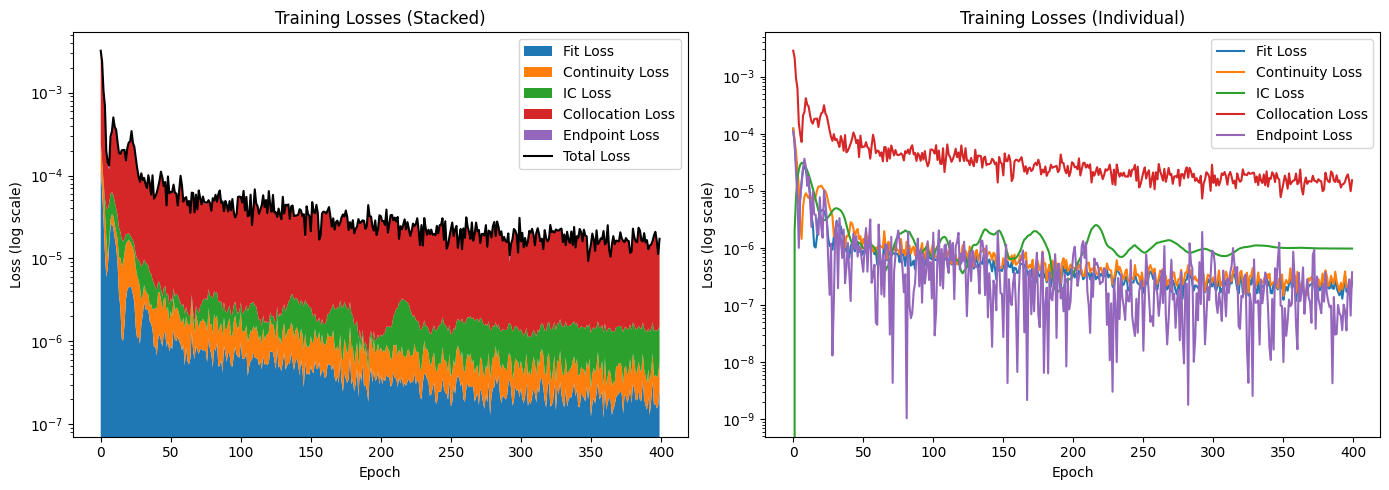

In [7]:
# Combined loss visualizations: stacked (left) and individual lines (right)
epochs = list(range(len(fit_losses)))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: stacked-area plot of all losses
ax1.stackplot(
    epochs,
    fit_losses,
    cont_losses,
    ic_losses,
    colloc_losses,
    end_losses,
    labels=['Fit Loss', 'Continuity Loss', 'IC Loss', 'Collocation Loss', 'Endpoint Loss']
)
# Overlay total loss line
total_losses = [
    f + c + ic + colloc + e
    for f, c, ic, colloc, e in zip(fit_losses, cont_losses, ic_losses, colloc_losses, end_losses)
]
ax1.plot(epochs, total_losses, label='Total Loss', color='black', linewidth=1.5)
ax1.set_yscale('log')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (log scale)')
ax1.set_title('Training Losses (Stacked)')
ax1.legend(loc='upper right')

# Right: individual loss component lines
ax2.plot(epochs, fit_losses,    label='Fit Loss')
ax2.plot(epochs, cont_losses,   label='Continuity Loss')
ax2.plot(epochs, ic_losses,     label='IC Loss')
ax2.plot(epochs, colloc_losses, label='Collocation Loss')
ax2.plot(epochs, end_losses,    label='Endpoint Loss')
ax2.set_yscale('log')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss (log scale)')
ax2.set_title('Training Losses (Individual)')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()



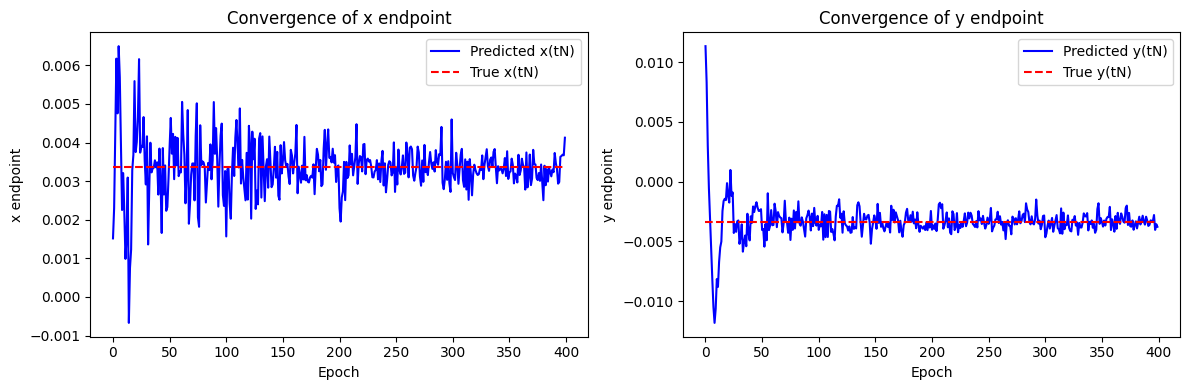

In [8]:
# Plot convergence of predicted endpoints
x_true_final, y_true_final = solution([tN])
x_true_final = x_true_final.item()
y_true_final = y_true_final.item()

epochs_end = list(range(len(x_end_preds)))
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(12, 4))

# x endpoint
ax3.plot(epochs_end, x_end_preds, label='Predicted x(tN)', color='blue')
ax3.hlines(x_true_final, 0, len(epochs_end)-1,
           linestyles='--', label='True x(tN)', color='red')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('x endpoint')
ax3.set_title('Convergence of x endpoint')
ax3.legend()

# y endpoint
ax4.plot(epochs_end, y_end_preds, label='Predicted y(tN)', color='blue')
ax4.hlines(y_true_final, 0, len(epochs_end)-1,
           linestyles='--', label='True y(tN)', color='red')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('y endpoint')
ax4.set_title('Convergence of y endpoint')
ax4.legend()

plt.tight_layout()
plt.show()



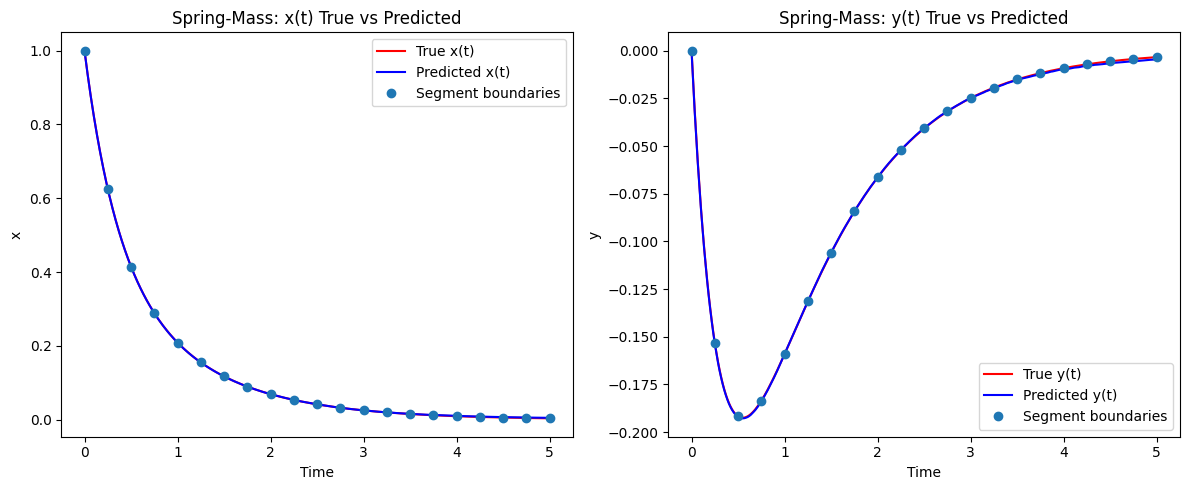

In [9]:
# 5) Now generate a high-resolution prediction on our test times:
with torch.no_grad():
    # assume s[0] is our learned initial state at t0
    y_test_pred = odeint(odefunc, s[0], t_test, method=test_integrator).squeeze(1)
    # y_test_pred: [len(t_test), state_dim]

# unpack predictions and true solution
x_pred = y_test_pred[:, 0].cpu()
y_pred = y_test_pred[:, 1].cpu()
t_vals = t_test.cpu()

x_true, y_true = solution(t_vals)
x_true = x_true.cpu()
y_true = y_true.cpu()

# Compute true values at segment boundaries
t_seg_cpu = t_grid.cpu()
x_seg_boundaries, y_seg_boundaries = solution(t_seg_cpu)
x_seg_boundaries = x_seg_boundaries.cpu()
y_seg_boundaries = y_seg_boundaries.cpu()

# Combined x(t) and y(t) subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
# Left subplot: x(t)
ax1.plot(t_vals, x_true, label='True x(t)', color='red')
ax1.plot(t_vals, x_pred, label='Predicted x(t)', color='blue')
ax1.plot(t_seg_cpu, x_seg_boundaries, linestyle='None', marker='o', label='Segment boundaries')
ax1.set_xlabel('Time')
ax1.set_ylabel('x')
ax1.set_title('Spring-Mass: x(t) True vs Predicted')
ax1.legend()
# Right subplot: y(t)
ax2.plot(t_vals, y_true, label='True y(t)', color='red')
ax2.plot(t_vals, y_pred, label='Predicted y(t)', color='blue')
ax2.plot(t_seg_cpu, y_seg_boundaries, linestyle='None', marker='o', label='Segment boundaries')
ax2.set_xlabel('Time')
ax2.set_ylabel('y')
ax2.set_title('Spring-Mass: y(t) True vs Predicted')
ax2.legend()
plt.tight_layout()
plt.show()

# # 6) Plot x(t):
# plt.figure()
# plt.plot(t_vals, x_true, label='True x(t)')
# plt.plot(t_vals, x_pred, label='Predicted x(t)')
# plt.plot(t_seg_cpu, x_seg_boundaries, linestyle='None', marker='o', label='Segment boundaries')
# plt.xlabel('Time')
# plt.ylabel('x')
# plt.legend()
# plt.title('Spring-Mass: x(t) True vs Predicted')
# plt.show()

# # 7) Plot y(t):
# plt.figure()
# plt.plot(t_vals, y_true, label='True y(t)')
# plt.plot(t_vals, y_pred, label='Predicted y(t)')
# plt.plot(t_seg_cpu, y_seg_boundaries, linestyle='None', marker='o', label='Segment boundaries')
# plt.xlabel('Time')
# plt.ylabel('y')
# plt.legend()
# plt.title('Spring-Mass: y(t) True vs Predicted')
# plt.show()